In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import make_swiss_roll
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

from lamp import Pinv_ilamp
from NNinv import NNinv_torch
from rbf_inv import RBFinv
from multilateration import MDSinv
from gradient_map import get_gradient_map

## get data

In [2]:
## load iris
iris = load_iris()
X = iris.data
y = iris.target

# scale data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## DM using MDS

C:\Users\yuwan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


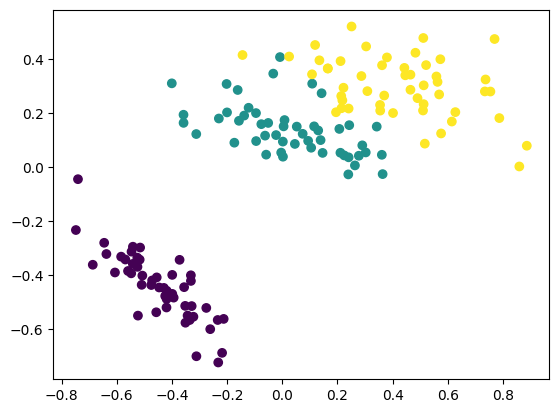

In [3]:
mds = MDS(n_components=2, max_iter=100, random_state=42)
X2d = mds.fit_transform(X)

# plt
plt.scatter(X2d[:, 0], X2d[:, 1], c=y, cmap='viridis')

## build $P^{-1}$

In [4]:
ilamp = Pinv_ilamp(k=6)
ilamp.fit(X2d, X)

nninv = NNinv_torch()
nninv.fit(X2d, X, epochs=100)

rbfinv = RBFinv()
rbfinv.fit(X2d, X)

mdsinv_rand = MDSinv(point_selection='random')
mdsinv_rand.fit(X2d, X)

mdsinv_closest = MDSinv(point_selection='closest')
mdsinv_closest.fit(X2d, X)

mdsinv_furthest = MDSinv(point_selection='furthest')
mdsinv_furthest.fit(X2d, X)

device:  cuda:0
Epoch 1/100, Loss: 0.08314672
Epoch 2/100, Loss: 0.09233338
Epoch 3/100, Loss: 0.07412231
Epoch 4/100, Loss: 0.06860625
Epoch 5/100, Loss: 0.05764104
Epoch 6/100, Loss: 0.05181656
Epoch 7/100, Loss: 0.04384357
Epoch 8/100, Loss: 0.02949230
Epoch 9/100, Loss: 0.02042627
Epoch 10/100, Loss: 0.01294219
Epoch 11/100, Loss: 0.01363841
Epoch 12/100, Loss: 0.00996504
Epoch 13/100, Loss: 0.00887578
Epoch 14/100, Loss: 0.01098165
Epoch 15/100, Loss: 0.01405898
Epoch 16/100, Loss: 0.01665640
Epoch 17/100, Loss: 0.01450323
Epoch 18/100, Loss: 0.01338748
Epoch 19/100, Loss: 0.00958325
Epoch 20/100, Loss: 0.00975419
Epoch 21/100, Loss: 0.01144402
Epoch 22/100, Loss: 0.00800824
Epoch 23/100, Loss: 0.00850421
Epoch 24/100, Loss: 0.00676812
Epoch 25/100, Loss: 0.00694214
Epoch 26/100, Loss: 0.00581829
Epoch 27/100, Loss: 0.00589069
Epoch 28/100, Loss: 0.00558903
Epoch 29/100, Loss: 0.00565700
Epoch 30/100, Loss: 0.00542990
Epoch 31/100, Loss: 0.00491839
Epoch 32/100, Loss: 0.00480344
E

In [31]:
xmin, xmax = X2d[:,0].min(), X2d[:,0].max()
ymin, ymax = X2d[:,1].min(), X2d[:,1].max()

inv_methods = {
    'iLAMP': ilamp,
    'NNInv': nninv,
    'RBF': rbfinv,
    'iMDS (random)': mdsinv_rand,
    'iMDS (closest)': mdsinv_closest,
    'iMDS (furthest)': mdsinv_furthest
}

map_grid = 500  ### could set it to 100 for faster computation

grad_map_dict = {}
nD_grids_dict = {}
global_min = 1e10
global_max = -1e10
for name, inv in inv_methods.items():
    grad_map, nD_grid = get_gradient_map(inv, X2d, map_grid)
    grad_map_dict[name] = grad_map.reshape(map_grid, map_grid)
    print(min(grad_map), max(grad_map))

    if max(grad_map) < 500:  ### need to somehow handle the super large values, if we want the scale the colorbar properly
        global_max = max(global_max, max(grad_map))
    global_min = min(global_min, min(grad_map))
        
    nD_grids_dict[name] = nD_grid



100%|██████████| 251946/251946 [00:00<00:00, 498624.84it/s]


0.3715246738412773 330.8586661458523
0.6460673 4.4153657
0.875395997294651 10.113874715641474
1.409660533784096 249.87193321262865
1.751197013091664 229.14290955569788
1.1988548921568813 35658.18305375504


In [32]:
print(global_min, global_max)

0.3715246738412773 330.8586661458523


## plot gradient map
### scale the color map globally

0.0 1.0
0.0008307211 0.012236
0.0015246321572727412 0.029478756717756533
0.0031412292028031555 0.7549474010622517
0.004174662690673039 0.6922247681495085
0.0025033658333290126 107.8947016524123


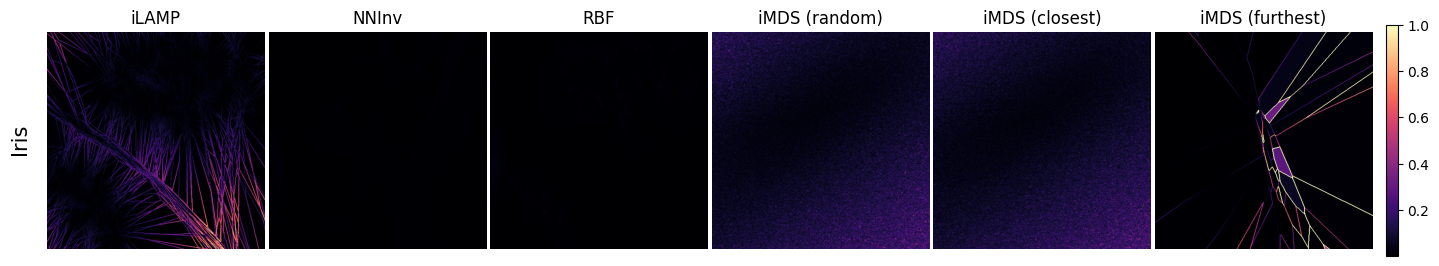

In [33]:

fig, axes = plt.subplots(1, 6, figsize=(18, 3))

X2d_scaled = (X2d - X2d.min(axis=0)) / (X2d.max(axis=0) - X2d.min(axis=0))


# white space
fig.subplots_adjust(wspace=0.02)

for i, (name, grad_map) in enumerate(grad_map_dict.items()):
    ax = axes[i]
    scaled_grad_map = (grad_map - global_min) / (global_max - global_min)
    print(scaled_grad_map.min(), scaled_grad_map.max())

    # flipp the x axis
    scaled_grad_map = np.flip(scaled_grad_map, axis=0)
    
    ## scaled globally
    image = cm.magma(scaled_grad_map)
    im = ax.imshow(image, cmap='magma', extent=[0, 1, 0, 1])
    ax.set_title(name)
    ax.axis('off')

    ## plot the original data
    # ax.scatter(X2d_scaled[:,0], X2d_scaled[:,1], c='#BBBBBB', s=1, marker='.')

    ## set aspect
    # ax.set_aspect('equal')
    

fig.text(0.11, 0.5, 'Iris', ha='center', va='center', rotation='vertical', fontsize=15)
fig.colorbar(im,  ax=axes, orientation='vertical', fraction=0.04, pad=0.01, )




### Scale the color individually

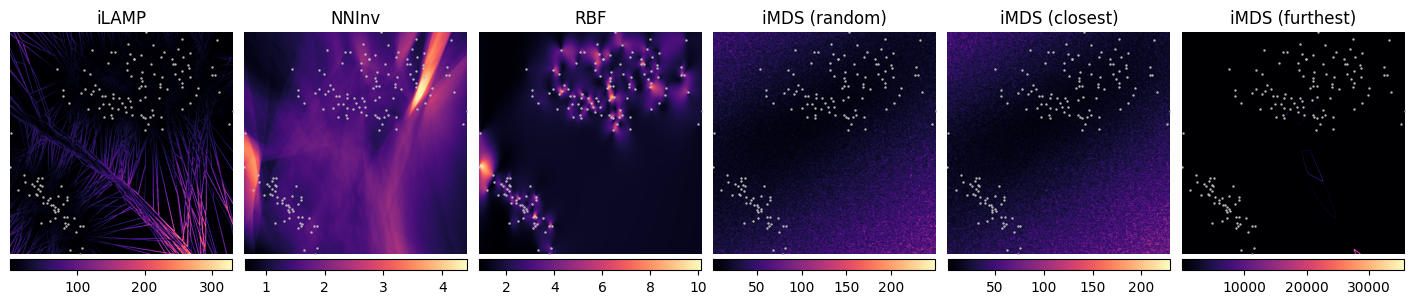

In [46]:


fig, axes = plt.subplots(1, 6, figsize=(18, 3.1))
X2d_scaled = (X2d - X2d.min(axis=0)) / (X2d.max(axis=0) - X2d.min(axis=0))

# white space
fig.subplots_adjust(wspace=0.05)

for i, (name, grad_map) in enumerate(grad_map_dict.items()):
    ax = axes[i]
    # flipp the x axis
    grad_map = np.flip(grad_map, axis=0)    

    ### scaled individually
    im = ax.imshow(grad_map, cmap='magma', extent=[0,1,0,1]) ## this will rescale the data to [0,1]
    
    ax.set_title(name)
    ax.axis('off')

    ## plot the 2d data
    ax.scatter(X2d_scaled[:,0], X2d_scaled[:,1], c='#BBBBBB', s=2, marker='.')

    ## set aspect
    ax.set_aspect('equal')

    # colorbar for each
    fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.0465, pad=0.02, )
    



# plt.tight_layout()

## save the figure
plt.savefig('./figures/iris_gradient_map.png', dpi=300)


## Make decision maps 

In [35]:
clf = LogisticRegression()
clf.fit(X, y)
print(clf.score(X, y))

0.94


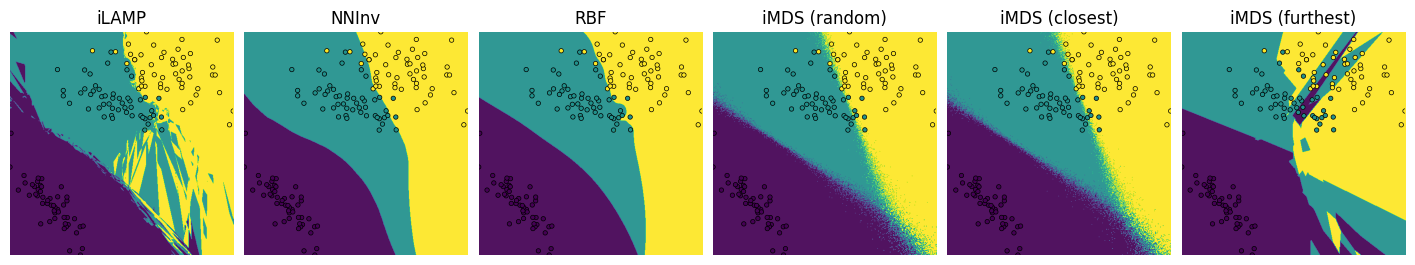

In [41]:
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
X2d_scaled = (X2d - X2d.min(axis=0)) / (X2d.max(axis=0) - X2d.min(axis=0))

# white space
fig.subplots_adjust(wspace=0.05)

for i, (name, nD_grids) in enumerate(nD_grids_dict.items()):
    ax = axes[i]
    
    labels = clf.predict(nD_grids.reshape(-1, X.shape[1]))
    ## flipp the x axis
    labels = np.flip(labels.reshape(map_grid, map_grid), axis=0)
    

    im = ax.imshow(labels, cmap='viridis', extent=[0,1,0,1], alpha=0.93) ## this will rescale the data to [0,1]
    ax.set_title(name)

    ## plot the 2d data
    ax.scatter(X2d_scaled[:,0], X2d_scaled[:,1], c=y, cmap='viridis', s=10, marker='o', ec='k', lw=0.5)

    ## set aspect
    ax.set_aspect('equal')

    ax.axis('off')

## save the figure
plt.savefig('./figures/iris_LogisticRegression_DBM.png', dpi=300)
